In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
import os
import json
import pandas as pd
from tools import SetUpScenario, getData, AvgBalAnalyser
from offset_funcs import schedule_offsetfn_from_eventlist, schedule_offsetfn_increasing_sinusoid, schedule_offsetfn_read_file
import yfinance as yf
from modules import Indicators
from analyse_performance import *


In [37]:
# Define the ticker symbol for Bitcoin (BTC-USD)
btc = yf.Ticker("BTC-USD")

btc_data = btc.history(start="2025-04-04", end="2025-04-05", interval='5m')
btc_data
btc_data.to_csv('MarketData/offset_BTC_USD_20250404_1D_5Min.csv')

In [ ]:
directory = 'tape/test4-0'
files = os.listdir(directory)
tape = files[-2]
list_of_tapes = []

for tape in files:
    tape_df = pd.read_csv(os.path.join(directory,tape), sep=',', names = ['trade', 'time', 'price'])
    tape_df['time'] = pd.to_timedelta(tape_df['time'], unit='s') + pd.Timestamp('2024-01-01')
    tape_df = tape_df.set_index('time')
    tape_df_resampled = tape_df.resample('300S').agg({'price': 'last'}) # 5 minutes
    resampled_indicators = Indicators(tape_df_resampled)
    resampled_indicators.add_ema_custom(mu=12, col='price')
    resampled_indicators.add_ema_custom(mu=24, col='price')

    resampled_indicators.data['MACD'] = resampled_indicators.data['EMA12'] - resampled_indicators.data['EMA24']
    resampled_indicators.add_ema_custom(mu=9, col='MACD')

    tape_df = resampled_indicators.data
    list_of_tapes.append(tape_df)



In [ ]:
def generate_position(tape_df):
    tape_df['positions'] = 0
    tape_df.loc[tape_df['MACD'] > tape_df['EMA9'], 'positions'] = 1
    tape_df.loc[tape_df['MACD'] <= tape_df['EMA9'], 'positions'] = -1
    return tape_df



def evaluate_performance(data: pd.DataFrame) -> dict:
    data = data.copy()

    tape_df['positions'] = tape_df['positions'].shift(1)
    tape_df['positions'] = tape_df['positions'].fillna(0)
    
    data['Return'] = data['price'].pct_change().fillna(0)
    
    data['StrategyReturn'] = data['Return'] * data['positions']
    
    data['CumulativeStrategyReturn'] = (1 + data['StrategyReturn']).cumprod() - 1
    sharpe_ratio = (data['StrategyReturn'].mean() / data['StrategyReturn'].std()) 

    cumulative_pnl = (1 + data['price'].pct_change() * data['positions'].shift(1)).cumprod() -1  # assume initial capital=500

    cumulative = (1 + data['StrategyReturn']).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    return data, {
        "Sharpe": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Cumulative Return": data['CumulativeStrategyReturn'].iloc[-1],
        # "Cumulative_pnl": cumulative_pnl
    }


    
with open(f'statistical_methods/technical/{directory.split('/')[-1]}.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name', 'sharpe', 'max_drawdown', 'cumulative_return'])
    for index, tape in enumerate(list_of_tapes):
        tape_df = generate_position(tape)
        _, stats = evaluate_performance(tape)
        print(f'Tape: {files[index]}, \n {stats}')
        writer.writerow([files[index], stats['Sharpe'], stats['Max Drawdown'], stats['Cumulative Return']])
    
    
    

Tape: test4-0_4_tape.csv, 
 {'Sharpe': 0.09177384882460997, 'Max Drawdown': -0.29596857128186826, 'Cumulative Return': 1.9265283423692825}
Tape: test4-0_5_tape.csv, 
 {'Sharpe': 0.11149237143148814, 'Max Drawdown': -0.2533715240482161, 'Cumulative Return': 2.654811956399712}
Tape: test4-0_3_tape.csv, 
 {'Sharpe': 0.16101369155901885, 'Max Drawdown': -0.15879442195231677, 'Cumulative Return': 6.643224672644271}
Tape: test4-0_2_tape.csv, 
 {'Sharpe': 0.19815321748494027, 'Max Drawdown': -0.24460505937016014, 'Cumulative Return': 12.393839366484876}
Tape: test4-0_7_tape.csv, 
 {'Sharpe': 0.08791668432603812, 'Max Drawdown': -0.18653613856970458, 'Cumulative Return': 1.5467134566590568}
Tape: test4-0_6_tape.csv, 
 {'Sharpe': 0.13277407927930054, 'Max Drawdown': -0.2704116683401152, 'Cumulative Return': 4.341455291961154}
Tape: test4-0_0_tape.csv, 
 {'Sharpe': 0.12583916043466198, 'Max Drawdown': -0.25760431922511107, 'Cumulative Return': 3.4620849411107066}
Tape: test4-0_1_tape.csv, 
 {'Sh

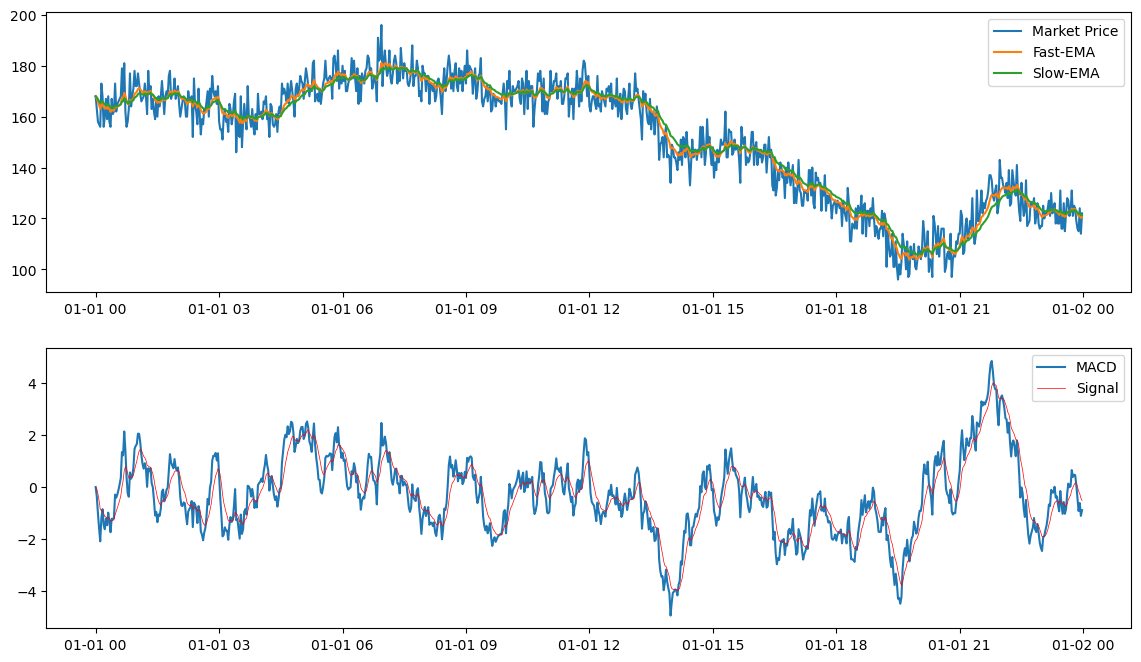

In [5]:
fig, axes= plt.subplots(2,1, figsize=(14,8))

axes[0].plot(tape_df.index, tape_df['price'], label = 'Market Price')
axes[0].plot(tape_df.index, tape_df['EMA12'], label = 'Fast-EMA')
axes[0].plot(tape_df.index, tape_df['EMA24'], label = 'Slow-EMA')
# axes[0].plot(tape_df.index, tape_df['MA25'], label = 'MA')

axes[1].plot(tape_df.index, tape_df['MACD'], label = 'MACD')
axes[1].plot(tape_df.index, tape_df['EMA9'], label = 'Signal', color='red', linewidth=0.5)

axes[0].legend()
axes[1].legend()


plt.show()

{'Sharpe': 0.14128989085998717, 'Max Drawdown': -0.2753866074849423, 'Cumulative Return': 157.8752653925408}


KeyError: 'time'

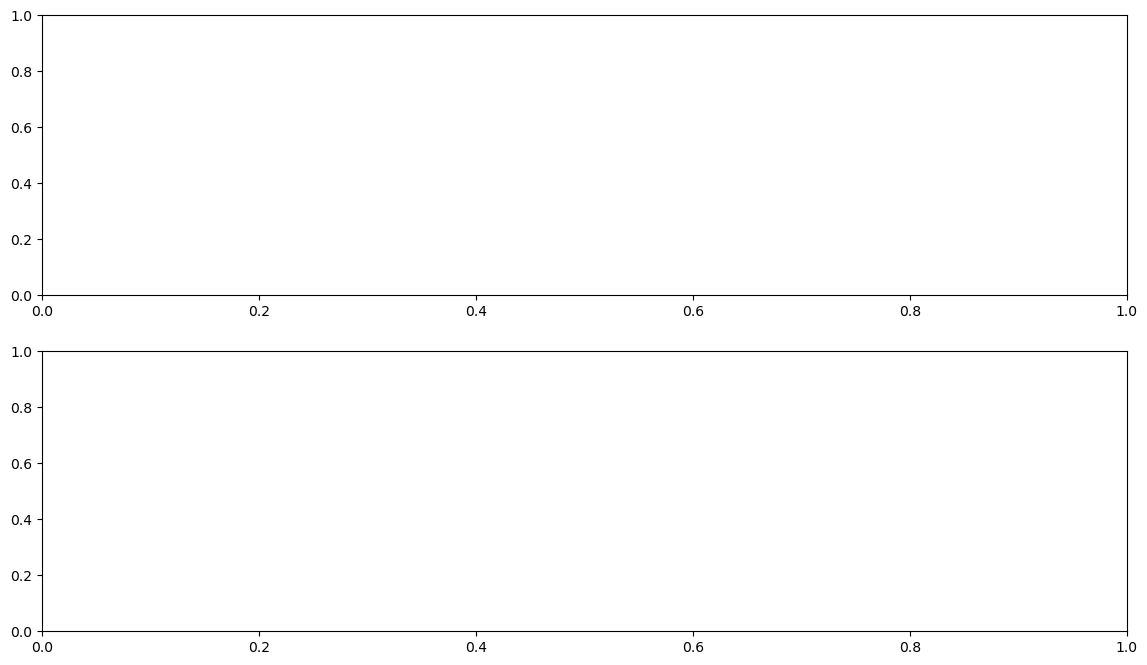

In [ ]:
#Figures:
# fig, axes= plt.subplots(2,1, figsize=(14,8))
# period = (5000,13000)

# axes[0].plot(tape_df['time'][period[0]:period[1]], tape_df['price'][period[0]:period[1]], label = 'Market Price')
# axes[0].plot(tape_df['time'][period[0]:period[1]], tape_df['EMA12'][period[0]:period[1]], label = 'Fast-EMA')
# axes[0].plot(tape_df['time'][period[0]:period[1]], tape_df['EMA24'][period[0]:period[1]], label = 'Slow-EMA')
# axes[0].plot(tape_df['time'][period[0]:period[1]], tape_df['MA25'][period[0]:period[1]], label = 'MA')

# axes[1].bar(tape_df['time'][period[0]:period[1]], tape_df['MACD'][period[0]:period[1]], label = 'MACD')
# axes[1].plot(tape_df['time'][period[0]:period[1]], tape_df['EMA9'][period[0]:period[1]], label = 'Signal', color='red', linewidth=0.5)

# axes[0].legend()
# axes[1].legend()


plt.show()

In [8]:
tape_df['positions'] = 0
tape_df.loc[tape_df['MACD'] > tape_df['EMA9'], 'positions'] = 1
tape_df.loc[tape_df['MACD'] <= tape_df['EMA9'], 'positions'] = -1



def evaluate_performance(data: pd.DataFrame) -> dict:
    data = data.copy()

    tape_df['positions'] = tape_df['positions'].shift(1)
    tape_df['positions'] = tape_df['positions'].fillna(0)
    
    data['Return'] = data['price'].pct_change().fillna(0)
    
    data['StrategyReturn'] = data['Return'] * data['positions']
    
    data['CumulativeStrategyReturn'] = (1 + data['StrategyReturn']).cumprod() - 1
    sharpe_ratio =  (data['StrategyReturn'].mean() / data['StrategyReturn'].std())
    cumulative_pnl = (1 + data['price'].pct_change() * data['positions'].shift(1)).cumprod() -1  # assume initial capital=500

    cumulative = (1 + data['StrategyReturn']).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    return data, {
        "Sharpe": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Cumulative Return": data['CumulativeStrategyReturn'].iloc[-1],
        "Cumulative_pnl": cumulative_pnl
    }

df, stats = evaluate_performance(tape_df)
# print(df.head())
print(stats)

{'Sharpe': 0.14128989085998717, 'Max Drawdown': -0.2753866074849423, 'Cumulative Return': 157.8752653925408, 'Cumulative_pnl': time
2024-01-01 00:00:00         NaN
2024-01-01 00:01:40    0.029762
2024-01-01 00:03:20    0.061350
2024-01-01 00:05:00    0.068067
2024-01-01 00:06:40    0.074870
                         ...   
2024-01-01 23:51:40   -0.999999
2024-01-01 23:53:20   -0.999999
2024-01-01 23:55:00   -0.999999
2024-01-01 23:56:40   -0.999999
2024-01-01 23:58:20   -0.999999
Freq: 100S, Length: 864, dtype: float64}


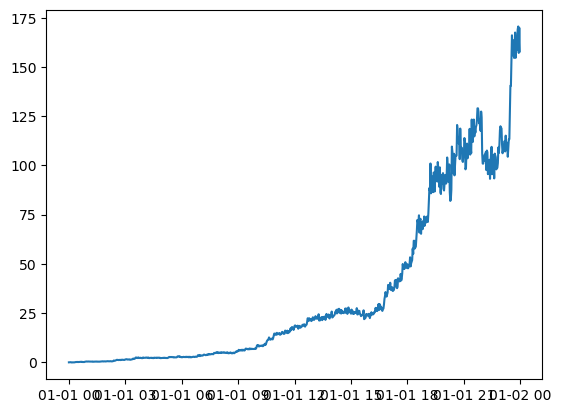

In [11]:
# plt.plot(df['StrategyReturn'][1:])
# plt.plot(df['Return'][1:])
plt.plot(df['CumulativeStrategyReturn'][:])